### Imported the relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn import svm


In [ ]:
crew_data = pd.read_csv("C:/Users/TruptiJadhav/Downloads/Ship_Crew_Size.csv")
crew_data.head()

In [16]:
print(crew_data.shape)

(158, 9)


#### Data Exploration: Observations:
     Data has 9 columns and 158 obeservations
    1) Ship_Name and Cruise_Line are nominal categorical variables (Taking few values, not continous ,not ordinal but discrete) 
    2) age,Tonnage, Passengers, Lenght, cabins,Passenger density are all continuos (Input )variables. 
    3) Crew - again a continuous variable , and target/Output variable
    4) Column names are unique, no need of renaming etc.

#### Evaluate whether the data needs cleaning; your model is only as good as the data it's given. 

In [5]:
crew_data.isnull().sum()

Ship_name            0
Cruise_line          0
Age                  0
Tonnage              0
passengers           0
length               0
cabins               0
passenger_density    0
crew                 0
dtype: int64

### There are no missing values for this data. Perfect data to use.
We will check the basic variable characteristics such as mean, standard deviation, percentiles,min,max etc

In [17]:
crew_data.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


### With the above table, it is visible that there are no outliers or exceptionally different data in the respective column.Hence no outlier treatment needed.

Further let's investigate the variable relationship to get the trend, we will use only continuos variable here to plot

C:\Users\TruptiJadhav\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


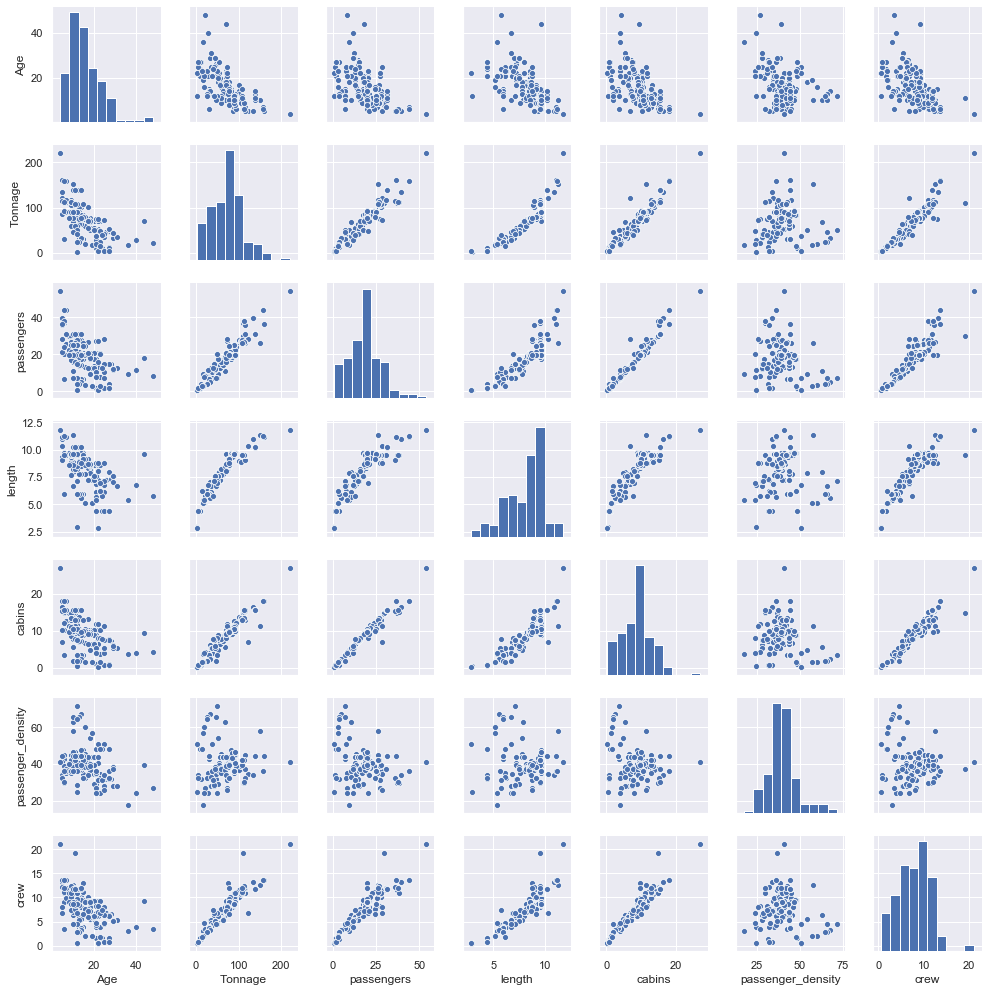

In [18]:
variables = ['Age', 'Tonnage', 'passengers', 'length', 'cabins','passenger_density','crew']
sns.pairplot(crew_data[variables], size=2.0)

 ###  Obeservations:
 1. Tonnage, Passengers, length ,cabins all these variables looks positively correlated with Crew
 2. Age looks negatively correlated with Crew
 3. Passenger_density does not show very specific trend.
 4. All other variables except Tonnage are in same range of values.  But this suggests that we should standardize the values.

In [19]:
scale = preprocessing.StandardScaler()
X_std = scale.fit_transform(crew_data[variables].iloc[:,range(0,7)].values)
cov_mat =np.cov(X_std.T)
print(cov_mat)


[[ 1.00636943 -0.61051007 -0.51882598 -0.53567624 -0.51326756 -0.28060619
  -0.53403648]
 [-0.61051007  1.00636943  0.9510809   0.92824328  0.95480665 -0.04110641
   0.93347689]
 [-0.51882598  0.9510809   1.00636943  0.8891624   0.9825601  -0.29674522
   0.92106365]
 [-0.53567624  0.92824328  0.8891624   1.00636943  0.89546571 -0.09106483
   0.90156272]
 [-0.51326756  0.95480665  0.9825601   0.89546571  1.00636943 -0.25479336
   0.9568788 ]
 [-0.28060619 -0.04110641 -0.29674522 -0.09106483 -0.25479336  1.00636943
  -0.15649979]
 [-0.53403648  0.93347689  0.92106365  0.90156272  0.9568788  -0.15649979
   1.00636943]]


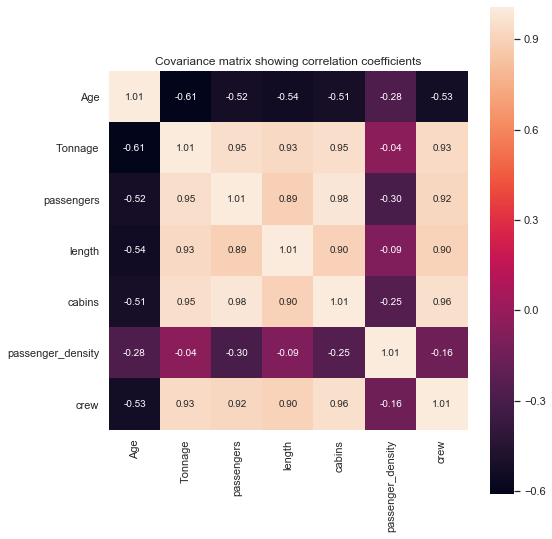

In [20]:
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.0)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt=".2f",
                 annot_kws={'size': 10},
                 yticklabels=variables,
                 xticklabels=variables)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Covariance matrix showing correlation coefficients')
plt.tight_layout()
plt.show()

From the covariance matrix plot above, we see that the “crew” variable correlates strongly with 4 predictor variables: “Tonnage”, “passengers”, “length, and “cabins”. and not with age & passenger_density.
Next we'll convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts     only the feature data we want to work with (exclude ship_name,Cruise_line) and another array that contains the crew (label).

In [25]:
variables_selected = ['Ship_name','Cruise_line','Tonnage', 'passengers', 'length', 'cabins','crew']
crew_selected= crew_data[variables_selected]
crew_selected.head()

,Ship_name,Cruise_line,Tonnage,passengers,length,cabins,crew
0,Journey,Azamara,30.277,6.94,5.94,3.55,3.55
1,Quest,Azamara,30.277,6.94,5.94,3.55,3.55
2,Celebration,Carnival,47.262,14.86,7.22,7.43,6.70
3,Conquest,Carnival,110.000,29.74,9.53,14.88,19.10
4,Destiny,Carnival,101.353,26.42,8.92,13.21,10.00


In [29]:
encoder=ce.OneHotEncoder(cols='Ship_name',handle_unknown='return_nan',return_df=True,use_cat_names=True)
#Fit and transform Data
data_encoded = encoder.fit_transform(crew_selected)
data_encoded.head()

,Ship_name_Journey,Ship_name_Quest,Ship_name_Celebration,Ship_name_Conquest,Ship_name_Destiny,Ship_name_Ecstasy,Ship_name_Elation,Ship_name_Fantasy,Ship_name_Fascination,Ship_name_Freedom,Ship_name_Glory,Ship_name_Holiday,Ship_name_Imagination,Ship_name_Inspiration,Ship_name_Legend,Ship_name_Liberty*,Ship_name_Miracle,Ship_name_Paradise,Ship_name_Pride,Ship_name_Sensation,Ship_name_Spirit,Ship_name_Triumph,Ship_name_Valor,Ship_name_Victory,Ship_name_Century,Ship_name_Constellation,Ship_name_Galaxy,Ship_name_Infinity,Ship_name_Mercury,Ship_name_Millenium,Ship_name_Solstice,Ship_name_Summit,Ship_name_Xpedition,Ship_name_Zenith,Ship_name_Allegra,Ship_name_Atlantica,Ship_name_Classica,Ship_name_Europa,Ship_name_Fortuna,Ship_name_Magica,Ship_name_Marina,Ship_name_Mediterranea,Ship_name_Romantica,Ship_name_Serena,Ship_name_Victoria,Ship_name_Serenity,Ship_name_Symphony,Ship_name_QueenElizabethII,Ship_name_QueenMary2,Ship_name_QueenVictoria,Ship_name_Magic,Ship_name_Wonder,Ship_name_Amsterdam,Ship_name_Eurodam,Ship_name_Maasdam,Ship_name_Noordam,Ship_name_Oosterdam,Ship_name_Prinsendam,Ship_name_Rotterdam,Ship_name_Ryndam,Ship_name_Statendam,Ship_name_Veendam,Ship_name_Volendam,Ship_name_Westerdam,Ship_name_Zaandam,Ship_name_Zuiderdam,Ship_name_Armonia,Ship_name_Fantasia,Ship_name_Lirica,Ship_name_Melody,Ship_name_Musica,Ship_name_Opera,Ship_name_Rhapsody,Ship_name_Sinfonia,Ship_name_Crown,Ship_name_Dawn,Ship_name_Dream,Ship_name_Gem,Ship_name_Jewel,Ship_name_Majesty,Ship_name_PrideofAloha,Ship_name_PrideofAmerica,Ship_name_Sea,Ship_name_Star,Ship_name_Sun,Ship_name_Wind,Ship_name_Insignia,Ship_name_Nautica,Ship_name_Regatta,Ship_name_MarcoPolo,Ship_name_Arcadia,Ship_name_Artemis,Ship_name_Aurora,Ship_name_Oceana,Ship_name_Oriana,Ship_name_Ventura,Ship_name_Caribbean,Ship_name_Coral,Ship_name_Diamond,Ship_name_Emerald,Ship_name_Golden,Ship_name_Grand,Ship_name_Island,Ship_name_Pacific,Ship_name_Regal,Ship_name_Royal,Ship_name_Saphire,Ship_name_Tahitian,Ship_name_ExplorerII,Ship_name_Mariner,Ship_name_Navigator,Ship_name_PaulGauguin,Ship_name_Voyager,Ship_name_Adventure,Ship_name_Brilliance,Ship_name_Empress,Ship_name_Enchantment,Ship_name_Explorer,Ship_name_Grandeur,Ship_name_Independence,Ship_name_Liberty,Ship_name_Monarch,Ship_name_Oasis,Ship_name_Radiance,Ship_name_Serenade,Ship_name_Sovreign,Ship_name_Splendour,Ship_name_Vision,Ship_name_Cloud,Ship_name_Shadow,Ship_name_Whisper,Ship_name_Aries,Ship_name_Gemini,Ship_name_Libra,Ship_name_Pisces,Ship_name_Taurus,Ship_name_Virgo,Ship_name_Surf,Cruise_line,Tonnage,passengers,length,cabins,crew
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Azamara,30.277,6.94,5.94,3.55,3.55
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Azamara,30.277,6.94,5.94,3.55,3.55
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Before moving to model development and validation , train/test split the data. 60% for training, and 40% for testing.

In [30]:
encoder=ce.OneHotEncoder(cols='Cruise_line',handle_unknown='return_nan',return_df=True,use_cat_names=True)
#Fit and transform Data
data_encoded = encoder.fit_transform(data_encoded)
data_encoded.head()

,Ship_name_Journey,Ship_name_Quest,Ship_name_Celebration,Ship_name_Conquest,Ship_name_Destiny,Ship_name_Ecstasy,Ship_name_Elation,Ship_name_Fantasy,Ship_name_Fascination,Ship_name_Freedom,Ship_name_Glory,Ship_name_Holiday,Ship_name_Imagination,Ship_name_Inspiration,Ship_name_Legend,Ship_name_Liberty*,Ship_name_Miracle,Ship_name_Paradise,Ship_name_Pride,Ship_name_Sensation,Ship_name_Spirit,Ship_name_Triumph,Ship_name_Valor,Ship_name_Victory,Ship_name_Century,Ship_name_Constellation,Ship_name_Galaxy,Ship_name_Infinity,Ship_name_Mercury,Ship_name_Millenium,Ship_name_Solstice,Ship_name_Summit,Ship_name_Xpedition,Ship_name_Zenith,Ship_name_Allegra,Ship_name_Atlantica,Ship_name_Classica,Ship_name_Europa,Ship_name_Fortuna,Ship_name_Magica,Ship_name_Marina,Ship_name_Mediterranea,Ship_name_Romantica,Ship_name_Serena,Ship_name_Victoria,Ship_name_Serenity,Ship_name_Symphony,Ship_name_QueenElizabethII,Ship_name_QueenMary2,Ship_name_QueenVictoria,Ship_name_Magic,Ship_name_Wonder,Ship_name_Amsterdam,Ship_name_Eurodam,Ship_name_Maasdam,Ship_name_Noordam,Ship_name_Oosterdam,Ship_name_Prinsendam,Ship_name_Rotterdam,Ship_name_Ryndam,Ship_name_Statendam,Ship_name_Veendam,Ship_name_Volendam,Ship_name_Westerdam,Ship_name_Zaandam,Ship_name_Zuiderdam,Ship_name_Armonia,Ship_name_Fantasia,Ship_name_Lirica,Ship_name_Melody,Ship_name_Musica,Ship_name_Opera,Ship_name_Rhapsody,Ship_name_Sinfonia,Ship_name_Crown,Ship_name_Dawn,Ship_name_Dream,Ship_name_Gem,Ship_name_Jewel,Ship_name_Majesty,Ship_name_PrideofAloha,Ship_name_PrideofAmerica,Ship_name_Sea,Ship_name_Star,Ship_name_Sun,Ship_name_Wind,Ship_name_Insignia,Ship_name_Nautica,Ship_name_Regatta,Ship_name_MarcoPolo,Ship_name_Arcadia,Ship_name_Artemis,Ship_name_Aurora,Ship_name_Oceana,Ship_name_Oriana,Ship_name_Ventura,Ship_name_Caribbean,Ship_name_Coral,Ship_name_Diamond,Ship_name_Emerald,Ship_name_Golden,Ship_name_Grand,Ship_name_Island,Ship_name_Pacific,Ship_name_Regal,Ship_name_Royal,Ship_name_Saphire,Ship_name_Tahitian,Ship_name_ExplorerII,Ship_name_Mariner,Ship_name_Navigator,Ship_name_PaulGauguin,Ship_name_Voyager,Ship_name_Adventure,Ship_name_Brilliance,Ship_name_Empress,Ship_name_Enchantment,Ship_name_Explorer,Ship_name_Grandeur,Ship_name_Independence,Ship_name_Liberty,Ship_name_Monarch,Ship_name_Oasis,Ship_name_Radiance,Ship_name_Serenade,Ship_name_Sovreign,Ship_name_Splendour,Ship_name_Vision,Ship_name_Cloud,Ship_name_Shadow,Ship_name_Whisper,Ship_name_Aries,Ship_name_Gemini,Ship_name_Libra,Ship_name_Pisces,Ship_name_Taurus,Ship_name_Virgo,Ship_name_Surf,Cruise_line_Azamara,Cruise_line_Carnival,Cruise_line_Celebrity,Cruise_line_Costa,Cruise_line_Crystal,Cruise_line_Cunard,Cruise_line_Disney,Cruise_line_Holland_American,Cruise_line_MSC,Cruise_line_Norwegian,Cruise_line_Oceania,Cruise_line_Orient,Cruise_line_P&O,Cruise_line_Princess,Cruise_line_Regent_Seven_Seas,Cruise_line_Royal_Caribbean,Cruise_line_Seabourn,Cruise_line_Silversea,Cruise_line_Star,Cruise_line_Windstar,Tonnage,passengers,length,cabins,crew
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.277,6.94,5.94,3.55,3.55
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [31]:
print(data_encoded.shape)

(158, 163)


In [33]:
X = data_encoded.iloc[:,0:162].values    # features matrix 
y = data_encoded['crew'].values        # target variable

In [41]:
(X_train, X_test, y_train, y_test) = train_test_split( X, y, test_size=0.4, random_state=0)

## Linear Regression using Scikit learn

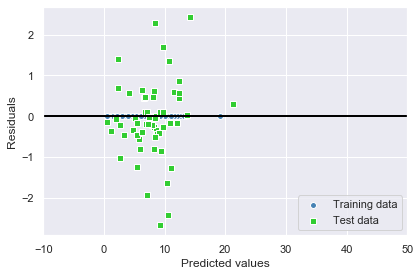

In [42]:
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

In [43]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


MSE train: 0.000, test: 0.825
R^2 train: 1.000, test: 0.933


The model performed really well on training data with 1 as   r2 score and with test data too the performance is  good.  As we have numerous features we can perform PCA and Lasso regularization.

In [57]:
slr.fit(X_train, y_train).intercept_

-1.2179235421159316

In [45]:
slr.fit(X_train, y_train).coef_

array([-1.00091385e-02, -1.00091385e-02,  1.52378110e-13,  6.62638598e+00,
       -1.03773326e+00,  4.30033595e-01,  4.30033595e-01,  1.28730360e-13,
       -4.02997080e-13,  2.25690814e-02,  2.42028619e-14,  3.84093014e-01,
        4.30033595e-01,  4.30033595e-01, -1.53368920e-01, -8.55924377e-01,
       -9.94204719e-14,  4.30033595e-01,  2.04030820e-01,  2.47579734e-14,
        9.05657862e-01, -8.84796044e-01,  7.20534743e-14,  3.16427204e-02,
        1.40443213e-14,  2.55849702e-01, -1.11410881e-13,  5.99520433e-15,
       -1.12111098e-01,  2.55849702e-01,  1.52766688e-13,  2.55849702e-01,
       -1.42302866e-01, -1.90958360e-14,  4.41361326e-01, -2.02131451e-01,
        5.17421315e-01,  9.99200722e-15, -6.01814377e-01, -6.01814377e-01,
        5.35682609e-15, -2.12254271e-01,  1.47676390e-01, -5.96744876e-16,
        8.32667268e-16,  1.22124533e-14,  1.51058656e-01, -4.27545371e-01,
        1.79372546e+00, -1.08662641e+00,  4.16324187e-01,  1.65423231e-14,
       -2.97043443e-02, -

In [58]:
X = data_encoded.iloc[:,0:162].values     
y = data_encoded['crew']  
from sklearn.preprocessing import StandardScaler
sc_y = StandardScaler()
sc_x = StandardScaler()
y_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
train_score = []
test_score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=i)
    y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline
    pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=4)),('slr', LinearRegression())])
    pipe_lr.fit(X_train, y_train_std)
    y_train_pred_std=pipe_lr.predict(X_train)
    y_test_pred_std=pipe_lr.predict(X_test)
    y_train_pred=sc_y.inverse_transform(y_train_pred_std)
    y_test_pred=sc_y.inverse_transform(y_test_pred_std)
    train_score = np.append(train_score, r2_score(y_train, y_train_pred))
    test_score = np.append(test_score, r2_score(y_test, y_test_pred))

In [59]:
train_score

array([0.88425899, 0.88031593, 0.9016165 , 0.89033905, 0.85614751,
       0.87313378, 0.90115038, 0.89474134, 0.89527638, 0.89786307])

In [60]:
test_score

array([0.81664333, 0.87860253, 0.75654372, 0.78285311, 0.88479222,
       0.84455115, 0.7843273 , 0.78895495, 0.7858353 , 0.79223569])

In [51]:
print('R2 train: %.3f +/- %.3f' % (np.mean(train_score),np.std(train_score)))

R2 train: 0.887 +/- 0.014


In [52]:
print('R2 test: %.3f +/- %.3f' % (np.mean(test_score),np.std(test_score)))

R2 test: 0.812 +/- 0.041


## Principal Component Analysis

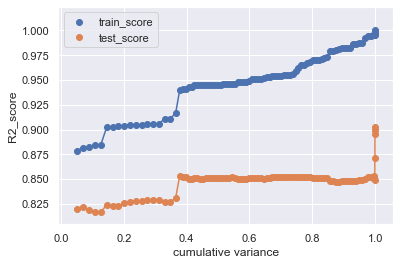

In [55]:
def create_model():
    model = Sequential()
    #48 feature inputs going into an 6-unit layer 
    model.add(Dense(6, input_dim=48, kernel_initializer='normal', activation='relu'))
    # "Deep learning" turns out to be unnecessary - this additional hidden layer doesn't help either.
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer with a binary classification (True or False)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model; adam seemed to work best
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

###  LASSO

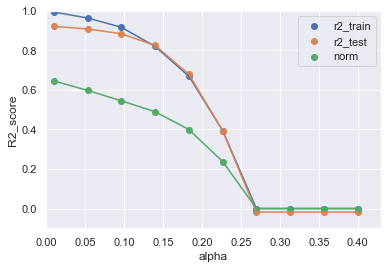

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)
y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_x.transform(X_test)
alpha = np.linspace(0.01,0.4,10) #lasso parameters
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.7)
r2_train=[]
r2_test=[]
norm = []
for i in range(10):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(X_train_std,y_train_std)
    y_train_std=lasso.predict(X_train_std)
    y_test_std=lasso.predict(X_test_std)
    r2_train=np.append(r2_train,r2_score(y_train,sc_y.inverse_transform(y_train_std)))
    r2_test=np.append(r2_test,r2_score(y_test,sc_y.inverse_transform(y_test_std)))
    norm= np.append(norm,np.linalg.norm(lasso.coef_))
plt.scatter(alpha,r2_train,label='r2_train')
plt.plot(alpha,r2_train)
plt.scatter(alpha,r2_test,label='r2_test')
plt.plot(alpha,r2_test)
plt.scatter(alpha,norm,label = 'norm')
plt.plot(alpha,norm)
plt.ylim(-0.1,1)
plt.xlim(0,.43)
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.legend()
plt.show()


### Accuracy using one hot encoding:
Though MSE and R2 has increased significantly after one hot encoding , please note that we had only 158 observations , out of which 60% are used for Model building.This will overfit the model.Hence we need to perform perform Principal Component Analysis and decrease the number of variables.
Post PCA and LASSO , we see the variables have reduced to significantly and still we can achieve better results.
R2 is interpreted as the proportion of the variance in the dependent variable that is predictable from the independent variables.
    
 Convergence at alpha=0.025
 We can see that there is no huge difference in in sample and out sample R2 scores so Lasso has resolved overfitting. One observation here is that after alpha= 0.014 there is no difference in R2 scores of train and test sample. We should check for Ridge too.
 